In [1]:
import dataInterpreter as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score

In [16]:
data = dt.get_data('biopsy', 'healthy', 'sars-cov2')
columns_healthy = dt.get_columns('biopsy', 'healthy')
columns_sars_cov2 = dt.get_columns('biopsy', 'sars-cov2')

filtered_data = dt.get_p_values('welch', data, columns_healthy, columns_sars_cov2)
filtered_data

,Series15_HealthyLungBiopsy_2,Series15_HealthyLungBiopsy_1,Series15_COVID19Lung_2,Series15_COVID19Lung_1,p-value
WASH7P,5.568345,4.948760,0.000000,0.000000,0.003453
LOC100133331,2.484907,3.091042,0.000000,0.000000,0.011611
LOC100288069,1.609438,1.945910,0.000000,0.000000,0.008838
LINC00115,3.951244,3.850148,0.000000,0.000000,0.000168
NOC2L,6.988413,7.595890,0.000000,0.693147,0.004373
...,...,...,...,...,...
USP9Y,5.564520,6.659294,0.693147,0.000000,0.012394
TMSB4Y,2.772589,2.639057,0.000000,0.000000,0.000608
BCORP1,2.833213,2.397895,0.000000,0.000000,0.006854
TTTY10,1.386294,1.609438,0.000000,0.000000,0.005503


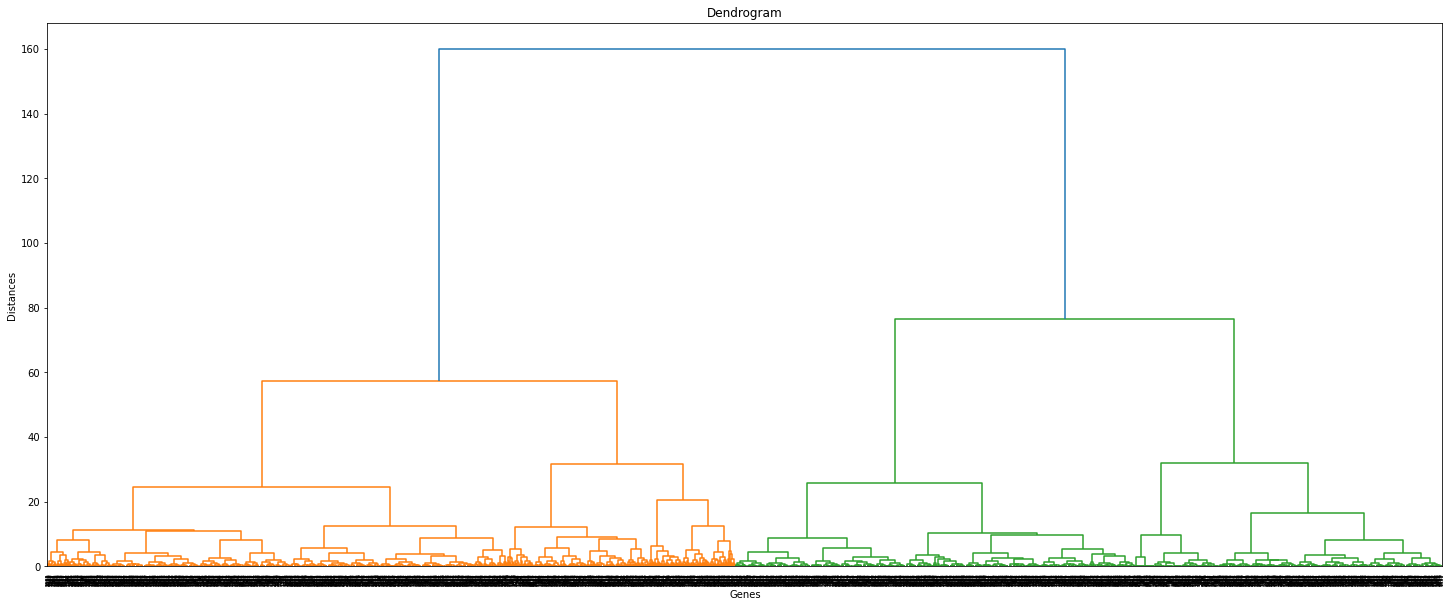

In [4]:
filtered_data.drop(['p-value'], axis = 1, inplace = True)
dt.plot_dendrogram(filtered_data)

In [5]:
labels = {}

models = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
labels['distance'] = models.fit_predict(filtered_data)

In [6]:
labels['distance']

array([0, 1, 2, ..., 1, 1, 1], dtype=int64)

In [8]:
dissimilarity = 1 - np.abs(filtered_data.T.corr())
m = squareform(dissimilarity)

m[np.abs(m) < 1e-12] = 0

hierarchy = linkage(m, method='ward')
labels['pearson'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [9]:
labels['pearson']

array([0, 2, 2, ..., 2, 0, 2], dtype=int32)

In [10]:
dissimilarity = 1 - np.abs(filtered_data.T.corr(method='spearman'))
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['spearman'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [11]:
labels['spearman']

array([0, 2, 0, ..., 0, 0, 2], dtype=int32)

In [12]:
from itertools import groupby

clusters = {}

for key1, label1 in labels.items():
    clusters[key1] = [list(map(lambda x: x[0], v)) for k,v in groupby(sorted(zip(filtered_data.index, labels['spearman']), key = lambda x: x[1]), lambda s: s[1])]
    
    for key2, label2 in labels.items():
        if key1 != key2:
            print(key1, ' vs ', key2, ': ', adjusted_rand_score(label1, label2))

distance  vs  pearson :  0.01696378009771689
distance  vs  spearman :  0.0035994757315617673
pearson  vs  distance :  0.01696378009771689
pearson  vs  spearman :  0.4307381756100609
spearman  vs  distance :  0.0035994757315617673
spearman  vs  pearson :  0.4307381756100609


In [ ]:
i = 0
for c in clusters['distance']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['pearson']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['spearman']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

## Clustering on columns

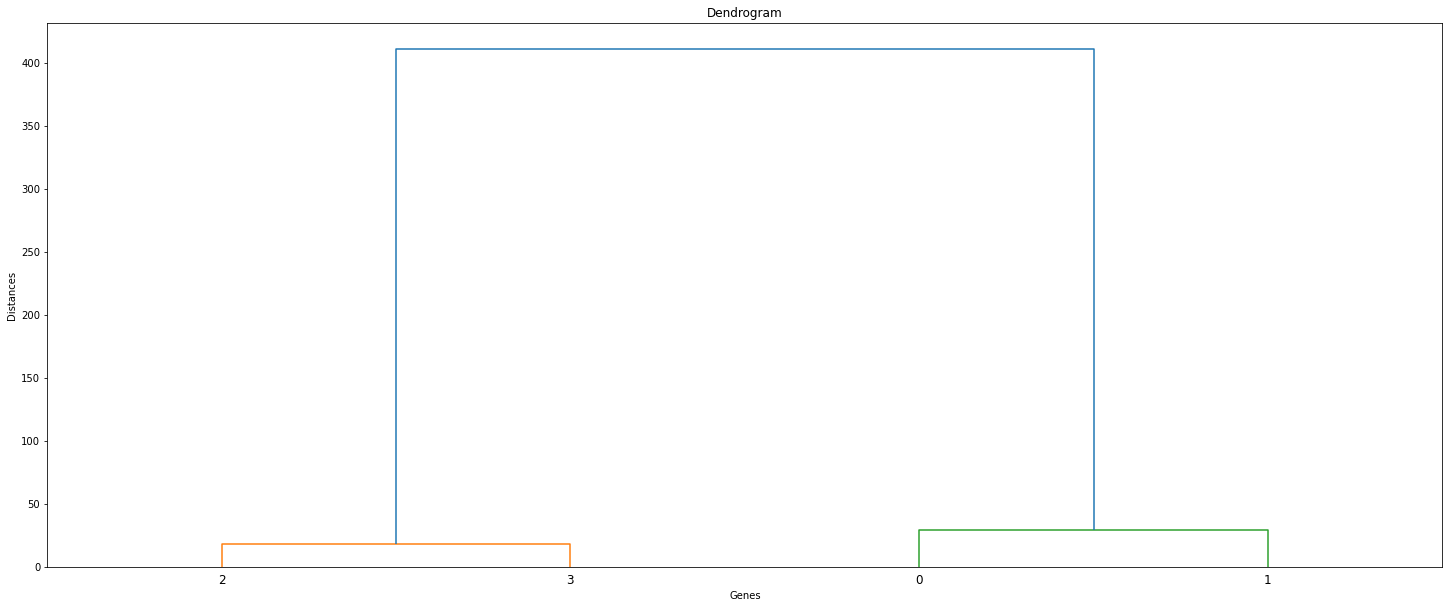

In [14]:
dt.plot_dendrogram(filtered_data.T)

In [15]:
labels_columns = {}

models = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
labels_columns['distance'] = models.fit_predict(filtered_data.T)

labels_true = [0 if col in columns_healthy else 1 for col in filtered_data.columns]

print("True: ", labels_true)
print("Predicted: ", labels_columns['distance'])
print(adjusted_rand_score(labels_true, labels_columns['distance']))

True:  [0, 0, 1, 1]
Predicted:  [0 0 1 1]
1.0
